# Implementation of CMFS, iCMFS on 20NG

In [1]:
"""
Authors: Abhirav Gholba
         Bhargav Srinivasa
         Devashish Deshpande
         Gauri Kholkar
         Mrunmayee Nasery
"""
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import operator
import math
%matplotlib inline

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
vec = CountVectorizer(stop_words='english')
document_term_mat = vec.fit_transform(newsgroups_train.data)
term_document_mat = document_term_mat.T
documents = len(newsgroups_train.filenames)
categories = len(newsgroups_train.target_names)
terms = term_document_mat.shape[0]

In [3]:
print "No. of documents: %d\nNo. of categories: %d" % (documents, categories)
print "matrix.shape: {0}".format(term_document_mat.shape)
print newsgroups_train.target[10]
print type(term_document_mat)

No. of documents: 11314
No. of categories: 20
matrix.shape: (101323, 11314)
8
<class 'scipy.sparse.csc.csc_matrix'>


### Create Term-category feature-appearance matrix

In [4]:
term_category_mat = np.zeros((terms, categories))
for doc in range(documents):
    cat = newsgroups_train.target[doc]
    for row in term_document_mat.getcol(doc).nonzero()[0]:
        term_category_mat[row][cat] += 1

In [5]:
print "Term-category matrix shape: {0} \n".format(term_category_mat.shape)

Term-category matrix shape: (101323, 20) 



### Perform CMFS, iCMFS and CC term-category matrix

In [6]:
cc_term_category_mat = np.copy(term_category_mat)
icmfs_term_category_mat = np.copy(term_category_mat)
cmfs_term_category_mat = np.copy(term_category_mat)

In [7]:
term_freq = np.sum(term_category_mat)
term_freq_per_cat = np.cumsum(term_category_mat, axis=0)[-1, :]

for term in range(terms):
    # Frequency of the term across all categories
    # ICMFS(tk,ci) = (P(tk|ci)*P(ci|tk))/P(ci)
    total_term_freq = sum(term_category_mat[term, :])
    for cat in range(categories):
        p_ci = float((term_freq_per_cat[cat] / term_freq))
        p_tk = float((total_term_freq / term_freq))
        p_ci_tk = float(term_category_mat[term][cat] + 1) / (total_term_freq + categories)
        p_tk_ci = float(term_category_mat[term][cat] + 1) / (term_freq_per_cat[cat] + terms)
        p_ntk_nci = float(term_freq - total_term_freq - term_freq_per_cat[cat] + term_category_mat[term][cat] + 1) / (term_freq - term_freq_per_cat[cat] + terms)
        p_tk_nci = float(total_term_freq - term_category_mat[term][cat] - 1) / (term_freq - term_freq_per_cat[cat] + terms)
        p_ntk_ci = float(term_freq_per_cat[cat] - term_category_mat[term][cat] - 1) / (term_freq_per_cat[cat] + terms)
        
        cc_term_category_mat[term][cat] = (math.sqrt(documents) * ((p_tk_ci * p_ntk_nci) - (p_tk_nci * p_ntk_ci))) / math.sqrt(p_tk * (1-p_tk) * p_ci * (1-p_ci))
        icmfs_term_category_mat[term][cat] = p_ci_tk * p_tk_ci / p_ci
        cmfs_term_category_mat[term][cat] = p_ci_tk * p_tk_ci
    
# Final CMFS matrix
print cc_term_category_mat
print icmfs_term_category_mat
print cmfs_term_category_mat

[[-1.78838352  1.13194884 -1.17605256 ..., -1.8480978  -0.40521161
  -1.51719869]
 [-0.61103784 -0.42400297 -2.15122478 ...,  3.48088231  1.17184346
  -0.51875683]
 [ 0.94644767  0.83129307  0.294858   ...,  1.09212797  0.68361091
   1.0000758 ]
 ..., 
 [ 3.27637045  3.00309585  1.75281203 ...,  1.84416838  2.65497586
   3.40416536]
 [ 3.27637045  3.00309585  1.75281203 ...,  1.84416838  2.65497586
   3.40416536]
 [ 3.27637045  3.00309585  1.75281203 ...,  1.84416838  2.65497586
   3.40416536]]
[[  7.74349505e-07   1.70632033e-04   3.28741992e-05 ...,   7.37862469e-06
    5.40474781e-05   3.30987341e-06]
 [  3.53866740e-05   5.03514822e-05   4.05411846e-06 ...,   6.60897657e-04
    2.01623925e-04   3.78141300e-05]
 [  7.54273777e-06   6.49250937e-06   2.64643844e-06 ...,   1.14997232e-05
    5.26462472e-06   8.06015469e-06]
 ..., 
 [  9.69780571e-06   8.34751204e-06   3.40256371e-06 ...,   3.69633960e-06
    6.76880321e-06   1.03630560e-05]
 [  9.69780571e-06   8.34751204e-06   3.40256

### Create term-cmfs dictionary

In [8]:
# Create term id (i.e. row no) - iCMFS dict, CMFS dict
term_icmfs_dict = {}
icmfs_max = np.max(icmfs_term_category_mat, axis=1)
term_cmfs_dict = {}
cmfs_max = np.max(cmfs_term_category_mat, axis=1)
for i in range(terms):
    term_icmfs_dict[i] = icmfs_max[i]
    term_cmfs_dict[i] = cmfs_max[i]    

### Extract top 2000 features

In [9]:
sorted_feature_list_cmfs = sorted(term_cmfs_dict.items(), key=operator.itemgetter(1), reverse=True)[:2000]
sorted_feature_list_icmfs = sorted(term_icmfs_dict.items(), key=operator.itemgetter(1), reverse=True)[:2000]

### Naive bayes

In [10]:
feature_list_cmfs = [term for term, _ in sorted_feature_list_cmfs]
# Create matrix for only the selected features. Note that the features are being extracted
# on the original document-term matrix. This will help in mapping with the targets easily.
selected_feature_matrix_cmfs = document_term_mat[:, feature_list_cmfs]
print selected_feature_matrix_cmfs.shape

feature_list_icmfs = [term for term, _ in sorted_feature_list_icmfs]
# Create matrix for only the selected features. Note that the features are being extracted
# on the original document-term matrix. This will help in mapping with the targets easily.
selected_feature_matrix_icmfs = document_term_mat[:, feature_list_icmfs]
print selected_feature_matrix_icmfs.shape

(11314, 2000)
(11314, 2000)


In [11]:
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
document_term_mat_test = vec.transform(newsgroups_test.data)
clf_cmfs = MultinomialNB().fit(selected_feature_matrix_cmfs, newsgroups_train.target)
clf_icmfs = MultinomialNB().fit(selected_feature_matrix_icmfs, newsgroups_train.target)

### Evaluate accuracy

In [12]:
pred_cmfs = clf_cmfs.predict(document_term_mat_test[:, feature_list_cmfs])
print metrics.f1_score(newsgroups_test.target, pred_cmfs, average='micro')
pred_icmfs = clf_icmfs.predict(document_term_mat_test[:, feature_list_icmfs])
print metrics.f1_score(newsgroups_test.target, pred_icmfs, average='micro')

0.592272968667
0.62599575146


In [13]:
icmfs_scores = []
for i in range(200, 2001, 200):
    feature_list_icmfs = [term for term, _ in sorted_feature_list_icmfs[:i]]
    selected_feature_matrix_icmfs = document_term_mat[:, feature_list_icmfs]
    clf_icmfs = MultinomialNB().fit(selected_feature_matrix_icmfs, newsgroups_train.target)
    pred_icmfs = clf_icmfs.predict(document_term_mat_test[:, feature_list_icmfs])
    f1_score_icmfs = metrics.f1_score(newsgroups_test.target, pred_icmfs, average='micro')
    icmfs_scores.append(f1_score_icmfs * 100)

cmfs_scores = []
for i in range(200, 2001, 200):
    feature_list_cmfs = [term for term, _ in sorted_feature_list_cmfs[:i]]
    selected_feature_matrix_cmfs = document_term_mat[:, feature_list_cmfs]
    clf_cmfs = MultinomialNB().fit(selected_feature_matrix_cmfs, newsgroups_train.target)
    pred_cmfs = clf_cmfs.predict(document_term_mat_test[:, feature_list_cmfs])
    f1_score_cmfs = metrics.f1_score(newsgroups_test.target, pred_cmfs, average='micro')
    cmfs_scores.append(f1_score_cmfs * 100)

### Test with chi2

In [14]:
ch2_scores = []
for i in range(200, 2001, 200):
    ch2 = SelectKBest(chi2, k=i)
    ch2_train = ch2.fit_transform(document_term_mat, newsgroups_train.target)
    ch2_test = ch2.transform(document_term_mat_test)
    clf = MultinomialNB().fit(ch2_train, newsgroups_train.target)
    pred = clf.predict(ch2_test)
    f1_score = metrics.f1_score(newsgroups_test.target, pred, average='micro')
    ch2_scores.append(f1_score * 100)

### Plot Accuracy vs Number of features graph

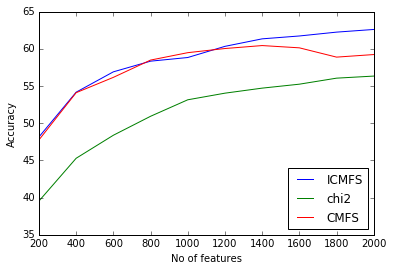

In [15]:
x = [i for i in range(200, 2001, 200)]
plt.plot(x, icmfs_scores, x, ch2_scores, x, cmfs_scores)
plt.xlabel("No of features")
plt.ylabel("Accuracy")
plt.legend(("ICMFS", "chi2", "CMFS"), loc='best')
plt.show()

### Plug in IGFSS

In [16]:
max_feature_column_cc = np.argmax(np.abs(cc_term_category_mat), axis = 1)
max_feature_sign_cc = np.empty_like(max_feature_column_cc)
for term in range(len(max_feature_column_cc)):
    max_val_col = max_feature_column_cc[term]
    max_feature_sign_cc[term] = np.sign(cc_term_category_mat[term][max_val_col])

In [17]:
cat_positive_negative = np.zeros(shape=(categories, 2), dtype=int)
final_term_list = []
nfrs = 0.2
for term, icmfs in sorted_feature_list_icmfs:
    sign = max_feature_sign_cc[term]
    cat = max_feature_column_cc[term]
    if ((float(cat_positive_negative[cat, 1]) / 100) < nfrs) and ((cat_positive_negative[cat, 0] + cat_positive_negative[cat, 1]) < 100):
        final_term_list.append(term)
        if sign > 0:
            cat_positive_negative[cat, 0] += 1
        else:
            cat_positive_negative[cat, 1] += 1
print cat_positive_negative

[[ 74   0]
 [ 67   0]
 [ 11  16]
 [100   0]
 [ 93   0]
 [100   0]
 [100   0]
 [ 82   0]
 [ 88   0]
 [100   0]
 [100   0]
 [100   0]
 [100   0]
 [ 95   0]
 [ 84   0]
 [100   0]
 [ 74   0]
 [100   0]
 [ 51   0]
 [ 23   0]]


In [21]:
for term, icmfs in sorted_feature_list_icmfs:
    if term not in final_term_list and len(final_term_list) < 2000:
        final_term_list.append(term)
print len(final_term_list)

2000
